In [1]:
import logging as log
log.basicConfig(level=log.INFO)

In [150]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

This is a test implementation of the PageRank algorithm in Python.

## Build Site Graph
We need a markov chain graph of N nodes with the requirements:
1. Disregard duplicate links
2. Disregard links to external sites
3. Disregard links to the same page
4. No dangling nodes (nodes with no links)

In [151]:
root = "http://ie.edu"
graph = {
    root: []
}
# DFS to build the graph
visited = set()
stack = [root]
while stack:
    current = stack.pop()
    if current in visited:
        continue
    visited.add(current)
    log.info(f"Visiting {current}")
    try:
        response = requests.get(current)
    except:
        continue
    soup = BeautifulSoup(response.text, "html.parser")
    for link in soup.find_all("a"):
        href = link.get("href")
        if href is None:
            continue
        if href.startswith("/"):
            href = root + href
        if not href.startswith(root):
            continue
        if href == current:
            continue
        graph.setdefault(current, []).append(href)
        if href not in graph:
            graph[href] = []
            stack.append(href)

INFO:root:Visiting http://ie.edu
INFO:root:Visiting http://ie.edu//www.ie.edu/school-of-humanities/
INFO:root:Visiting http://ie.edu//www.ie.edu/
INFO:root:Visiting http://ie.edu//www.ie.edu/school-science-technology/
INFO:root:Visiting http://ie.edu//www.ie.edu/ie-foundation/
INFO:root:Visiting http://ie.edu//www.ie.edu/school-architecture-design/
INFO:root:Visiting http://ie.edu//www.ie.edu/lifelong-learning/
INFO:root:Visiting http://ie.edu//www.ie.edu/law-school/
INFO:root:Visiting http://ie.edu//www.ie.edu/school-politics-economics-global-affairs/
INFO:root:Visiting http://ie.edu//www.ie.edu/university/
INFO:root:Visiting http://ie.edu//www.ie.edu/business-school/
INFO:root:Visiting http://ie.edu/centers/
INFO:root:Visiting http://ie.edu/centers/#chairs
INFO:root:Visiting http://ie.edu/centers/#observatories
INFO:root:Visiting http://ie.edu/centers/#centers
INFO:root:Visiting http://ie.edu/our-spaces/
INFO:root:Visiting http://ie.edu/who-we-are/
INFO:root:Visiting http://ie.edu/pr

Now we need to _clean_ the graph by removing dangling nodes and external links.

In [152]:
for i in range(2):
    for node in list(graph.keys()):
        if not graph[node]:
            del graph[node]
        else:
            graph[node] = [link for link in graph[node] if link in graph]
    # Remove nodes with no links
    for node in list(graph.keys()):
        if not graph[node]:
            del graph[node]
    # Remove external links
    for node in list(graph.keys()):
        graph[node] = [link for link in graph[node] if link.startswith(root)]

We can now visualize the graph using the `networkx` library.

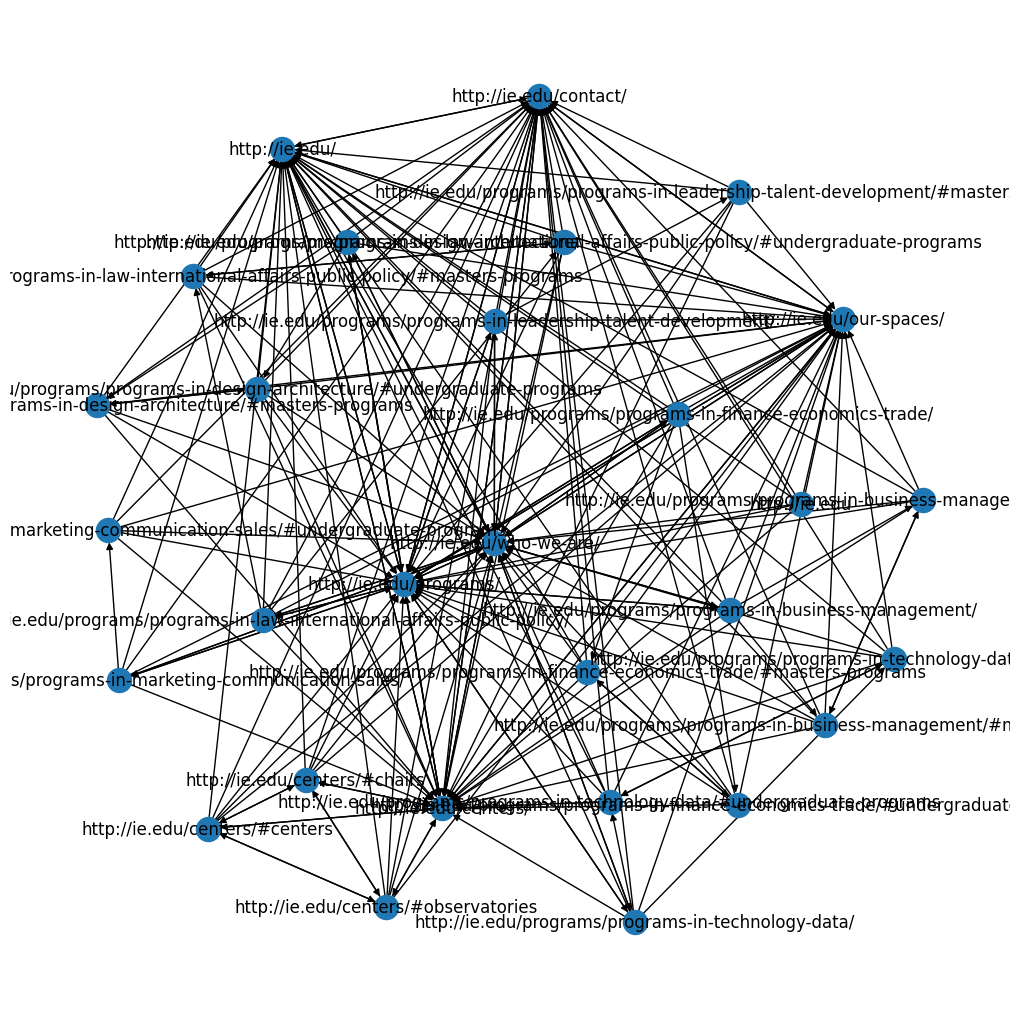

In [153]:
G = nx.DiGraph(graph)
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True)
plt.show()

In [154]:
# lets see how many nodes and edges we have
log.info(f"Nodes: {len(G.nodes)}")
log.info(f"Edges: {len(G.edges)}")

INFO:root:Nodes: 29
INFO:root:Edges: 213


## Mouse Click Model

In [155]:
counts = [1,10,100,1000,5000]
df = pd.DataFrame(columns=counts)

In [156]:
for count in counts:
    visits = {node: 0 for node in G.nodes}
    current = root
    for _ in range(count):
        visits[current] += 1
        current = np.random.choice(G[current])
    df[count] = pd.Series(visits)

In [157]:
df.sort_values(5000, ascending=False)

,1,10,100,1000,5000
http://ie.edu/who-we-are/,0,1,17,136,692
http://ie.edu/programs/,0,1,7,124,663
http://ie.edu/centers/,0,0,17,126,609
http://ie.edu/,0,1,11,119,580
http://ie.edu/contact/,0,1,8,124,578
http://ie.edu/our-spaces/,0,2,16,118,575
http://ie.edu/programs/programs-in-technology-data/,0,0,2,19,122
http://ie.edu/programs/programs-in-design-architecture/,0,0,2,26,119
http://ie.edu/programs/programs-in-marketing-communication-sales/,0,0,3,21,119
http://ie.edu/programs/programs-in-leadership-talent-development/,0,0,2,16,117


In [158]:
# top 3 pages
top3list = df.sort_values(5000, ascending=False).index[:3]; top3list

Index(['http://ie.edu/who-we-are/', 'http://ie.edu/programs/',
       'http://ie.edu/centers/'],
      dtype='object')

Our top 3 pages are: /who-we-are (1), /centers (2), /programs (3)
Lets plot a weighted graph of all the pages with the top 3 pages highlighted.

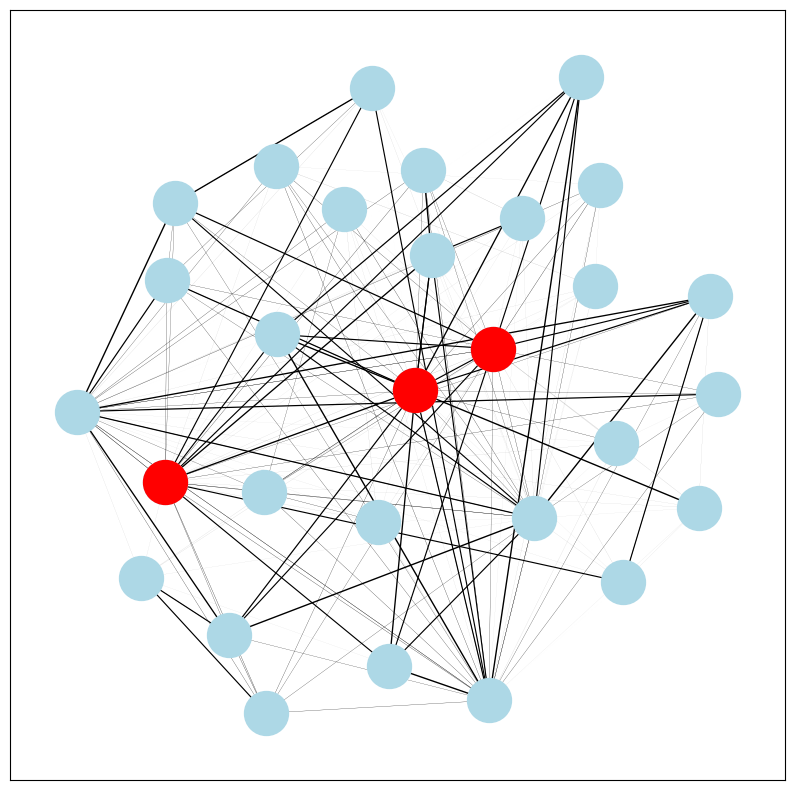

In [159]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
weights = [df.loc[node, 5000] for node in G.nodes]
weights = [weight / max(weights) for weight in weights]
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=weights)
nx.draw_networkx_nodes(G, pos, nodelist=top3list, node_size=1000, node_color="red")
plt.show()

We can now build an adjacency matrix from the graph and calculate the PageRank.

In [160]:
adjacency = nx.to_numpy_array(G)
# turn ot ints
adjacency = adjacency.astype(int)
# show latex
from IPython import display
# get Math and Latex
from IPython.display import Math, Latex
latex = pd.DataFrame(adjacency).style.to_latex()
# todo

## Simulation
assuming we start at a random page, we can calculate the PageRank for 5th click.

In [168]:
# forgot to normalize the adjacency matrix
norm_adjacency = adjacency / adjacency.sum(axis=0)
norm_adjacency = np.nan_to_num(norm_adjacency)
norm_adjacency

/tmp/ipykernel_168775/2581305582.py:2: RuntimeWarning: invalid value encountered in divide
  norm_adjacency = adjacency / adjacency.sum(axis=0)


array([[0.        , 0.03571429, 0.03571429, 0.03571429, 0.03571429,
        0.03571429, 0.03571429, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.03571429, 0.03571429, 0.03571429,
        0.03571429, 0.03571429, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.03571429, 0.        , 0.03571429, 0.03571429,
        0.03571429, 0.03571429, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
  

In [257]:
page = np.random.choice(list(set(G.nodes)))
log.info(f"Starting at {page}")
x_0 = np.zeros(len(G.nodes))
x_0[list(G.nodes).index(page)] = 1
x_0
x_n = []
for _ in range(5):
    x_n.append(x_0)
    x_0 = np.dot(norm_adjacency, x_0)
    visiting_page = list(G.nodes)[np.argmax(x_0)]
    log.info(f"Visiting {visiting_page}")

ValueError: probabilities do not sum to 1

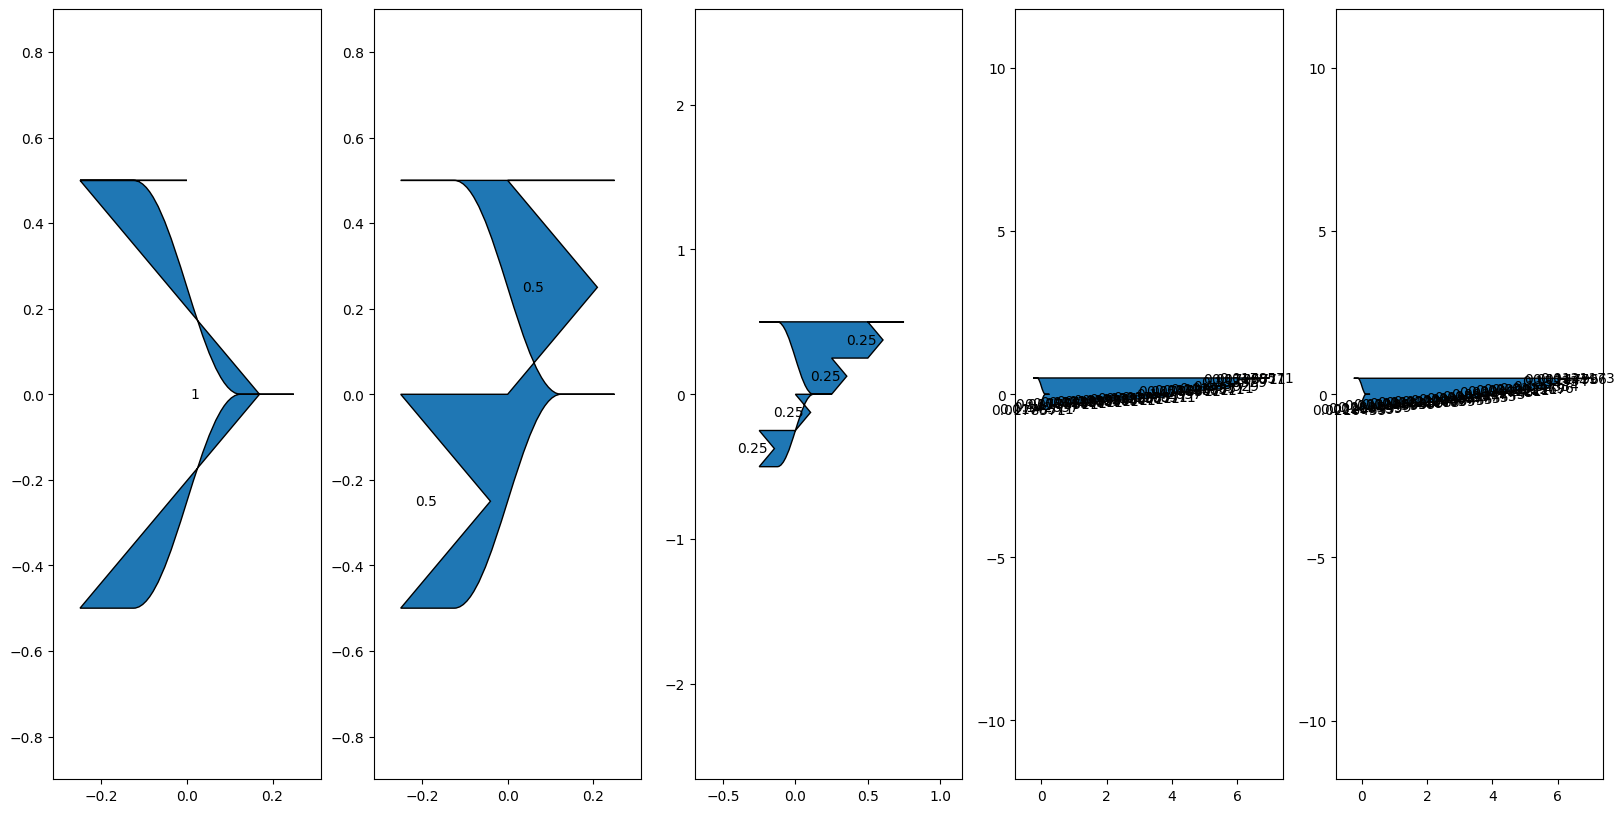

In [256]:
# silence the logging
log.getLogger().setLevel(log.WARNING)
## we make a sankey diagram to visualize the flow
from matplotlib.sankey import Sankey
# avoid the sankey being crowded and visualize in columns
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
lables = [title.split("/")[-2] for title in G.nodes]
for i, x in enumerate(x_n):
    sankey = Sankey(ax=ax[i])
    sankey.add(flows=x, orientations=[0]*len(G.nodes))
    sankey.finish()


This plot shows the flow of the PageRank algorithm through the pages of the website.